In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn

import dataset
import rendering
from model import Voxels
import train

Instead of sphere with few parameters we'll have voxels with way more parameters.
our sphere model isnt complex enough to fit to enough scenes

Therefore we'll move to voxels to represent more scenes, and finally we'll move to Neural Networks that can represent even more complex scenes


## 1. Camera / Dataset

- Instrinsic: intrinsic paramters eg. the camera parameters the orientation, focal length etc.
for NeRF we make sure the intrinsic parameters like focal length are the same for input image while the position is changing overtime.

- do not use autofocus on your phone use the same focal length for all images.
- most nerf code assumes that intrinsic params between input images remain the same

In [6]:
BATCH_SIZE = 1024
origin, direction, target_px_values = dataset.get_rays('fox/',mode='train')

dataloader = DataLoader(torch.cat((torch.from_numpy(origin).reshape(-1, 3), # [N*H*W, 3]
                                   torch.from_numpy(direction).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                        batch_size=BATCH_SIZE, shuffle=True)

# Warmup to precent mode collapse into local minima by only taking the centre of the images
dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(origin).reshape(90, 400, 400, 3) [:, 100:300, 100:300, :].reshape(-1, 3), # [N*H*W, 3]
                                   torch.from_numpy(direction).reshape(90, 400, 400, 3) [:, 100:300, 100:300, :].reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(90, 400, 400, 3) [:, 100:300, 100:300, :].reshape(-1, 3)), dim=1),
                        batch_size=BATCH_SIZE, shuffle=True)

test_origin, test_direction, test_target_px_values = dataset.get_rays('fox/', mode='test')


print(f"origin shape: {origin.shape}")
print(f"direction shape: {direction.shape}")
print(f"target_px_values shape: {target_px_values.shape}")
print(f"test_origin shape: {test_origin.shape}")
print(f"test_direction shape: {test_direction.shape}")
print(f"test_target_px_values shape: {test_target_px_values.shape}")

Mode: train
Image files length: 90
Pose files length: 90
Intrinsic files length: 90
Image size: (400, 400, 4)
(90, 400, 400, 4)
Mode: test
Image files length: 10
Pose files length: 10
Intrinsic files length: 10
Image size: (400, 400, 4)
(10, 400, 400, 4)
origin shape: (90, 160000, 3)
direction shape: (90, 160000, 3)
target_px_values shape: (90, 160000, 3)
test_origin shape: (10, 160000, 3)
test_direction shape: (10, 160000, 3)
test_target_px_values shape: (10, 160000, 3)


## 3. Rendering with Model

### The nerf model
- takes in 60 dim input
- L_pos for positional encoding = 10 and L_dir for directional encoding = 4
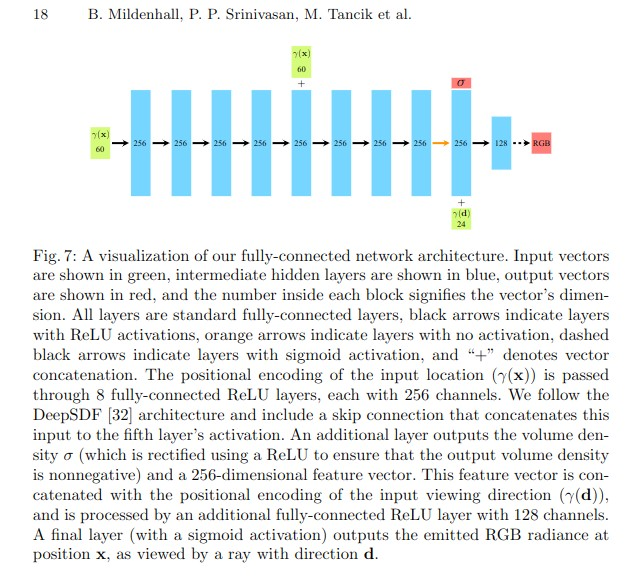

`note:` not mentioned in the papaer but in the implementation its not 60 but 63 inputs they take the input without encoding into account
- they will do the encoding then concat() the encoding alongside input P therefore 63
- the result will not be substansially differnet

1. First block has 5x hiddden layer with ReLU activations (black arrows)
2. 6th block uses skip connections with positional encoding inputs
3. 9th block has no activation (denoted by orange)
4. 10th block has 256 + sigma (1)
5. 10th block also takes L_direction (directional encoding), why is it taken so late?
    - because sigma shoudlnt depend on the dircetion, sigma is the density therefore only position.
6. 24 inputs of L_direction (directional encodings)
7. the last hidden layer has sigmoid activation as we want pixel values to be between 0-1
(denoted by dotted arrow)

`note:` they used 
- x, y, z, x_dir, y_dir, z_dir -> NN -> sigma, color ; instead of theta and phi in the input

8. sigma is density not is independant of direction unlike color which depends on direction as well as position
9. return sigma with `torch.relu()` to make sure densities are not negative
10. NeRF models are prone to mode collapse, therefore we might get sigma value desnity everywhere, 
11. overcome this by:
    - cropping the image, and using 1st epoch as warmup (seen before)
    - softplus activation (not as good coz its neever get density of 0)
    but its close to 0.
    - relu goes from 0-inifinty
    - Truncated exponential used in instant NGP


In [3]:
class Nerf(nn.Module):
    def __init__(self, L_position = 10, L_direction = 4, hidden_dim=256):
        super(Voxels, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Linear(L_position * (2 * 3) + 3, hidden_dim), # 2 for sin and cos and 3 for all 3 dimensions of P in positional encoding formula
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
        )
        
        
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim + (L_position * (2*3) + 3), hidden_dim), # skip connection iwth positional encodings from input added
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim + 1), # +1 for the sigma(density output) ps. doesn't depend on direction only the position
        )
        
        self.rgb_head = nn.Sequential(
            nn.Linear(hidden_dim + L_direction * (2 * 3) + 3, hidden_dim // 128), # directional encodings added 
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3), 
            nn.Sigmoid(),
        )
        
    def forward(self, xyz):
        x_embedding = ... ## [batch_size, L_position * (2*3) + 3]
        direction_embedding = ...
        
        h = self.block1(x_embedding) # [batch, hidden_dim]
        h = self.block2(torch.cat((h, x_embedding), dim=1)) #[batch_Size, hidden_dim + 1]
        sigma = h[:, -1] #density
        h = h[:, :-1]
        color = self.rgb_head(h)
        
        return color, torch.relu(sigma) #to get density always greater than zero
        
    def intersect(self, x):
        return self.forward(x)

KeyboardInterrupt: 

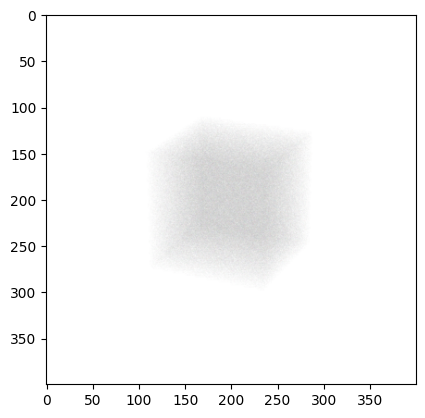

In [7]:
test_model = Voxels(scale=1)
img = rendering.rendering(test_model, torch.from_numpy(origin[0]), torch.from_numpy(direction[0]), 8, 12, white_background=True)
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())

In [4]:
for params in test_model.parameters():
    print(params)

Parameter containing:
tensor([[[[4.5362e-01, 4.3084e-01, 2.1270e-01, 1.5048e-01],
          [8.2035e-01, 8.7259e-01, 3.5476e-01, 2.7748e-01],
          [1.3431e-01, 3.1432e-01, 6.4490e-01, 2.8472e-01],
          ...,
          [7.3244e-01, 8.6823e-01, 6.9022e-01, 8.8212e-01],
          [6.0924e-01, 7.9914e-01, 8.1802e-01, 8.2311e-01],
          [2.3257e-01, 2.6238e-01, 2.5641e-01, 3.1257e-01]],

         [[7.0870e-01, 3.1039e-01, 7.4998e-02, 7.0822e-01],
          [4.2856e-01, 4.6307e-01, 8.8045e-01, 5.9237e-03],
          [4.0158e-01, 4.8951e-01, 2.2585e-01, 7.3407e-01],
          ...,
          [1.9064e-01, 6.8794e-01, 2.8037e-01, 2.0131e-01],
          [4.6665e-01, 7.9291e-01, 2.1574e-01, 4.2283e-01],
          [3.0962e-01, 4.5595e-01, 7.8623e-01, 2.9339e-01]],

         [[5.0137e-01, 2.6241e-01, 6.1910e-01, 3.2948e-01],
          [4.1303e-01, 7.7643e-01, 4.6052e-03, 2.7187e-01],
          [8.3110e-01, 1.0211e-01, 3.0393e-01, 4.3163e-01],
          ...,
          [5.0739e-01, 8.9830

## 4. Training

## warmup is need to prevent mode collapse for nerf models NOT voxels as they are robust to mode collapse problem 
- we cannot have mode collapse when working with voxels

100%|██████████| 3516/3516 [00:42<00:00, 83.06it/s] 


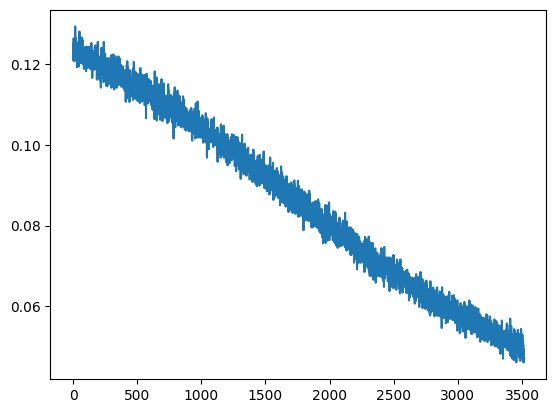

100%|██████████| 14063/14063 [02:56<00:00, 79.74it/s]


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparams
tn = 8
tf = 12
nb_epochs = 15
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

model = Nerf()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [5, 10], gamma=gamma)


#warmup on 1 epoch
training_loss = train.training(model, optimizer, scheduler, dataloader_warmup, tn, tf, nb_bins, 1, device)
plt.plot(training_loss)
plt.show()

training_loss = train.training(model, optimizer, scheduler, dataloader, tn, tf, nb_bins, nb_epochs, device)

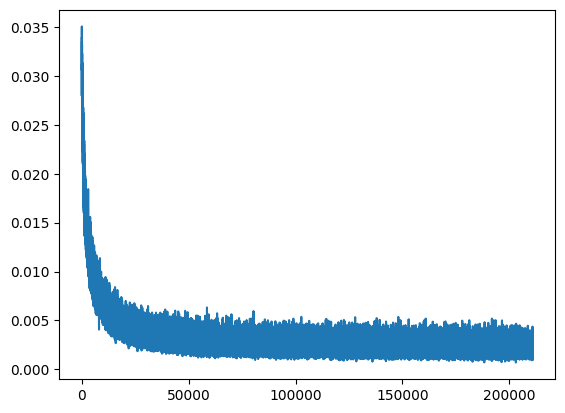

In [6]:
plt.plot(training_loss)

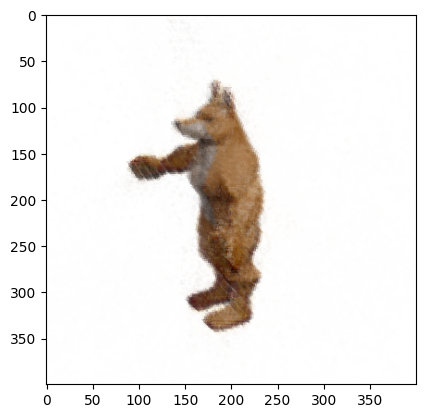

In [7]:
img = rendering.rendering(model, torch.from_numpy(origin[0]).to(device), torch.from_numpy(direction[0]).to(device), tn, tf, nb_bins = 100, device = device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

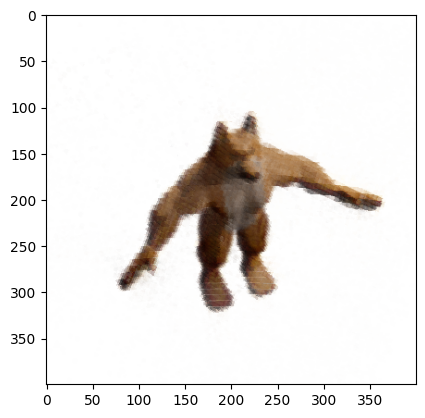

In [11]:
img = rendering.rendering(model, torch.from_numpy(origin[6]).to(device), torch.from_numpy(direction[6]).to(device), tn, tf, nb_bins = 100, device = device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

## Fix mode collapse on synthetic data
- in a mini batch we may get a lot of pixels that have the value zero (with white background regularization) therefore we have have mode collapse at zero ie. it outputs zero for any values. Therefore we are stuck in a local minima

### solutions:
- use TruncExp() used in instantngp
- use softprus
- on the first epoch only trian on the centre of the image

### note:
- we cannot have mode collapse with voxel models they are robust unlike NeRF models 

model has not overfit the training data

model has multi view consistency but errors in camera parameters might cause errors

after this
1. NeRF
2. 3D recon
3. view synthesis

there fore we can use eithe rhte nerf model or the voxel model

Voxels are working fine
issues:
- resolution is cubic

eg: we have 100 voxels we have total 3 sides therefore 100**3 = 1,000,000 => 1.0
thats not so much thats like a medium MLP and thats okay

but lets say we are recontructing a statue lets say its 1.5m
therefore we use scale of -1.5 to 1.5 m there fore scale of 3.
but lets say total is 1.5 scale. therfore obj is 1.5m in width
therefore each voxel / small box of 1.5 cm or 0.015 m
but for detailed statues that may not be enough therfore we gof from 1.5 cm to 0.001m or 0.1cm

lets say we use 1500**3 voxels then the no of voxels just explores to billions ie almost 3 billions parameters to optimize, voxels do not scale well to larger dimension. we assumed it was 1.5m object 

lets say it was a room instead that was 5mx5m or 10x10 the resolution just explodes, weren not able to model it with voxels

with voxels we are limited with size



## therefore we use Neural Netowrk
### with voxels
- x, y, z -> voxel -> sigma, color
### with neural networks we can get a continuous model.
- x, y, z -> NN -> sigma, color

we replace the black box with a NN 
we are not limited by the resolution

`note about voxels :` 
instead of 
x = 1.1
y = 1.0
z = 1.3

voxels(x, y, z) 

we could have used trilinear interpolation to get a continuous model from a discrete model.


x = 1.1
y = 1.0
z = 1.3

x = 1.15
y = 1.0
z = 1.3

voxels(1, 1, 1) 
voxels(2, 1, 1)


### with neural networks we can get a continuous model.
- x, y, z, theta, phi -> NN -> sigma, color

- to model the light field or how light propagrates
    - before assumed: color C only depends position of ray at time t
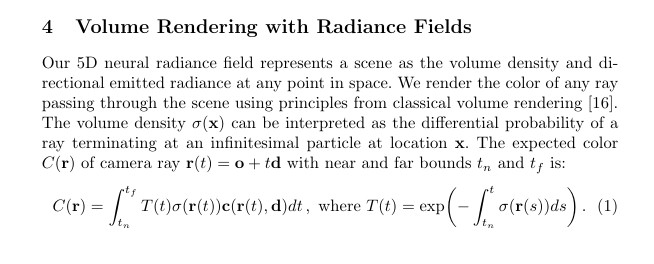
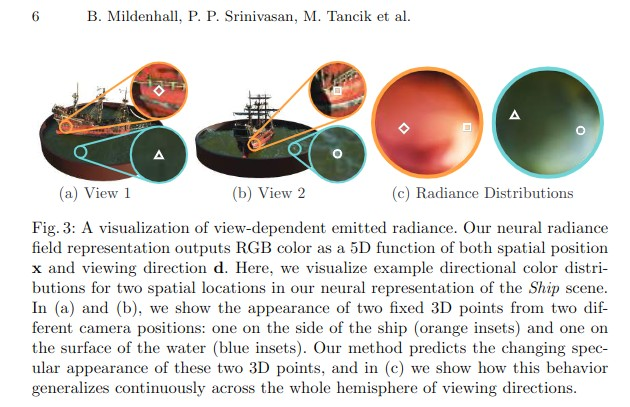
    
    - but it also depends on the viewing direction as color values from the same point change when viewed from a different angle.

sigma does not depend on theta and phi but the color does.
we cannot add theta and phi to voxel as it is a cubic representation.
as 100**5 is almost 10 billion parameters and 100 resolution is already too low for real life applications.

if we want to take the whole light field we need ot move to neural networks

## Positional Encoding

lets assume a 2D image and an MLP that will model the image
the model will take as input the pixel location (x, y) and output the pixel values at that location, its a very simple supervised leanring problem. that we can implement pretty quickly.

but even on the simple problem its not able to fit well. WHY?
- with ReLU activation function the NN is biased to learn Low Frequencies faster.

ie if 

x = 1. -> 100

x = 1.05 -> 1

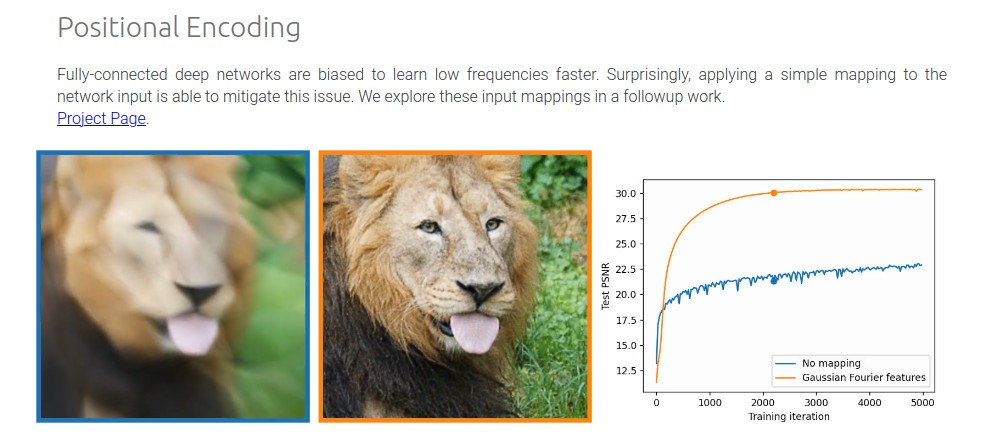

- as the output value changes very quickly with small change in input  

- abrupt change of pixel values with small changes inputs are high frequency functions eg blades of grass. NN are very bad at learning high frequency functions
therefore we use positional encoding

- relu activation functions are bad at reconstructing high frequency structures.
- use positional encoding to recon high frequency object


we implement the positional encoding 
- by mapping the input into higher dimensionality space and use sinosoids (cosine and sin)
- and feed that to the MLP. nothing complicated

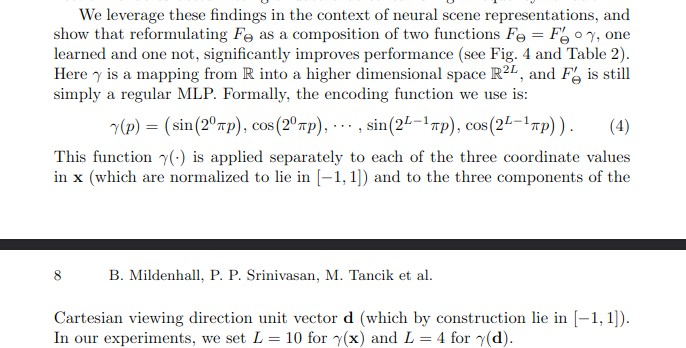

As you can see:
- P is our position and before pushing it directly to our NN we push to the encoding fn.
- uses sinosoids 
- allows network to learn high frequency details
- input is 60 dim, why 60?
    - L_pos = 10; L_dir = 4
    - 2 values for each L_pos => 10*2 
    - since p is 3d => 20 for x, y and z each => 20 + 20 + 20 = 60




## There are other methods like
>#### [Implicit Neural Representations with Periodic Activation Functions](https://arxiv.org/abs/2006.09661)

will discuss later! but for most nerf implementation positional encodings are enough